# Setup

In [1]:
import os, sys
sys.path.append(os.path.abspath(os.path.join('../../..'))) # access sibling directories
sys.path.append("C:\\Users\\lasse\\Documents\\GitHub\\BayesFlow")

from src.python.settings import summary_meta_validation, probability_meta_validation
from src.python.networks import HierarchicalInvariantNetwork, ModelProbabilityNetwork
from src.python.models import HierarchicalSdtMptSimulator, MainSimulator
from src.python.metrics import performance_metrics, bootstrapped_metrics
from src.python.helpers import n_clust_obs_f_f, log_with_inf_noise_addition, computation_times, get_repeated_predictions
from src.python.visualization import plot_approximations, plot_computation_times, plot_calibration_curve_repetition_uncertainty

import numpy as np
np.set_printoptions(suppress=True)
import pandas as pd
from functools import partial
import matplotlib.pyplot as plt

from bayesflow.trainers import ModelComparisonTrainer
from bayesflow.amortizers import MultiModelAmortizer

In [2]:
# Hack to correctly set facecolor to white
# matplotlib 3.5 only sets facecolor if a plot was already created 
_ = plt.figure()
plt.rcParams['figure.facecolor'] = 'w'

<Figure size 432x288 with 0 Axes>

# Load data

In [3]:
comparison_folder = os.path.join(os.path.dirname(os.path.dirname(os.path.dirname(os.getcwd()))),'data', '02_bridge_sampling_comparison', 'non_nested_models')
bridge_file = '2022_12_02_BF_BS'
NN_fixed_file = '2022_12_06_BF_NN_softmax_30epochs'

bridge = pd.read_csv(os.path.join(comparison_folder, bridge_file), sep = " ").reset_index(drop=True)
NN_fixed = pd.read_csv(os.path.join(comparison_folder, NN_fixed_file))

results_list = [bridge, NN_fixed]

In [4]:
NN_fixed

,dataset,true_model,m0_prob,m1_prob,selected_model,bayes_factor,training_time,inference_time,final_epoch_loss
0,1,0,0.986836,1.316385e-02,0,1.333945e-02,2154.584591,0.000181,0.19045
1,2,0,0.994437,5.562917e-03,0,5.594036e-03,2154.584591,0.000181,0.19045
2,3,0,1.000000,2.605674e-11,0,2.605674e-11,2154.584591,0.000181,0.19045
3,4,1,0.311261,6.887386e-01,1,2.212734e+00,2154.584591,0.000181,0.19045
4,5,0,0.999859,1.408465e-04,0,1.408664e-04,2154.584591,0.000181,0.19045
...,...,...,...,...,...,...,...,...,...
95,96,0,0.999863,1.370143e-04,0,1.370330e-04,2154.584591,0.000181,0.19045
96,97,0,0.516703,4.832972e-01,0,9.353484e-01,2154.584591,0.000181,0.19045
97,98,1,0.000001,9.999988e-01,1,8.388598e+05,2154.584591,0.000181,0.19045
98,99,1,0.000010,9.999901e-01,1,1.010666e+05,2154.584591,0.000181,0.19045


# Calculate performance metrics

In [5]:
n_bootstrap = 1000
names = ['Bridge sampling', 'Neural network']
metrics = ['Accuracy', 'ROC AUC', 'MAE', 'RMSE', 'Log score', 'SBC']

# Calculate performance metrics
perf_metrics = performance_metrics(results_list, names=names, metrics=metrics, model_prior=0.5)

# Calculate bootstrapped performance metrics
metrics_means, metrics_ses = bootstrapped_metrics(results_list, n_bootstrap=1000, names=names, metrics=metrics, model_prior=0.5)

In [9]:
# Raw results
perf_metrics

,Accuracy,ROC AUC,MAE,RMSE,Log score,SBC
Bridge sampling,0.95,0.9852,0.095463,0.218608,0.154887,-0.006345
Neural network,0.95,0.9848,0.096166,0.214380,0.155125,-0.002499


In [10]:
# Bootstrapped means
metrics_means

,Accuracy,ROC AUC,MAE,RMSE,Log score,SBC
Bridge sampling,0.94894,0.984895,0.096423,0.217634,0.157214,-0.005364
Neural network,0.94897,0.984327,0.097243,0.213675,0.157922,-0.001552


In [11]:
# Bootstrapped standard errors
metrics_ses

,Accuracy,ROC AUC,MAE,RMSE,Log score,SBC
Bridge sampling,0.022331,0.008831,0.019782,0.034828,0.043011,0.044716
Neural network,0.022571,0.009172,0.019047,0.034539,0.043638,0.044588


In [12]:
# Convert to latex table
metrics_means = metrics_means.round(2).drop('ROC AUC', axis=1) # drop ROC AUC column as results do not add much information
metrics_ses = metrics_ses.round(2).drop('ROC AUC', axis=1) # drop ROC AUC column as results do not add much information

for row in range(metrics_means.shape[0]):
    for col in range(metrics_means.shape[1]):
        metrics_means.iloc[row,col] = f'{metrics_means.iloc[row,col]}' + f' ({metrics_ses.iloc[row,col]})'

print(metrics_means.style.to_latex(position='h', position_float='centering', hrules=True))

\begin{table}[h]
\centering
\begin{tabular}{llllll}
\toprule
 & Accuracy & MAE & RMSE & Log score & SBC \\
\midrule
Bridge sampling & 0.95 (0.02) & 0.1 (0.02) & 0.22 (0.03) & 0.16 (0.04) & -0.01 (0.04) \\
Neural network & 0.95 (0.02) & 0.1 (0.02) & 0.21 (0.03) & 0.16 (0.04) & -0.0 (0.04) \\
\bottomrule
\end{tabular}
\end{table}



In [13]:
# How do the proportions of selected models look like?

print('True proportion = {}'.format(bridge['true_model'].mean()))
print('Bridge Sampling proportion = {}'.format(bridge['selected_model'].mean()))
print('NN proportion = {}'.format(NN_fixed['selected_model'].mean()))

True proportion = 0.5
Bridge Sampling proportion = 0.51
NN proportion = 0.51


# Plot PMPs & log BFs

In [13]:
# Compute Log BFs

log_bridge_bfs = log_with_inf_noise_addition(bridge)
log_NN_fixed_bfs = log_with_inf_noise_addition(NN_fixed)

In [14]:
model_names = ['SDT', 'MPT']

## BS vs fixed NN

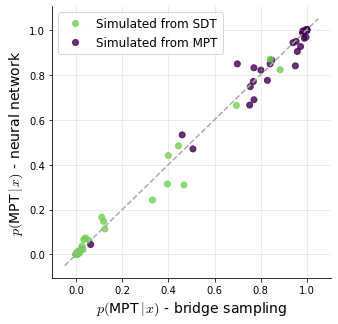

In [17]:
# PMPs
plot_approximations(bridge, NN_fixed, approximated_outcome='PMPs', 
                    NN_name='neural network', model_names=model_names, save=False)

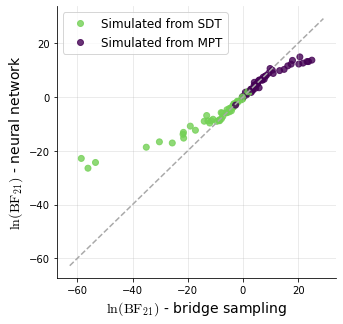

In [18]:
# Log BFs
plot_approximations(bridge, NN_fixed, approximated_outcome='Log BFs', 
                    NN_name='neural network', model_names=model_names, save=False)

# of included datasets: 85


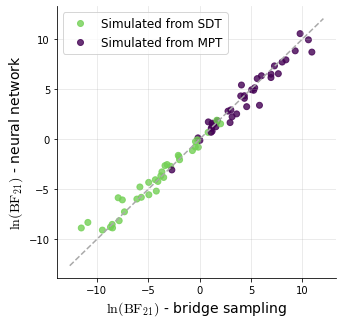

In [19]:
# Log Bfs with filter
filter_high = bridge['bayes_factor']<100000
filter_low = bridge['bayes_factor']>0.00001
bridge_filtered = bridge[filter_high & filter_low].reset_index(drop=True)
NN_fixed_filtered = NN_fixed[filter_high & filter_low].reset_index(drop=True)
print('# of included datasets: {}'.format(min([sum(filter_high), sum(filter_low)])))

plot_approximations(bridge_filtered, NN_fixed_filtered, approximated_outcome='Log BFs', 
                    NN_name='neural network', model_names=model_names, save=False)

# Find biggest discrepancies and compare implications

In [20]:
# Find biggest PMP discrepancies
divergence_fixed = np.argmax(abs(bridge["m1_prob"] - NN_fixed["m1_prob"]))

In [21]:
# Look up respective BFs: Bridge vs. fixed network
print(f'BF Bridge sampling: {bridge.loc[divergence_fixed, "bayes_factor"]}')
print(f'BF NN: {NN_fixed.loc[divergence_fixed, "bayes_factor"]}')

BF Bridge sampling: 0.878198779931907
BF NN: 0.4483317723918558


# Plot computation times as function of data sets

In [6]:
# Calculate computation times
results_time_list = computation_times(results_list)

In [7]:
# Mean computation times per phase
# Bridge Sampling
print('Stan: {}seconds / {}minutes'.format(round(np.mean(bridge['stan_time']), 2), round((np.mean(bridge['stan_time'])/60), 2)))
print('Bridge: {}seconds / {}minutes'.format(round(np.mean(bridge['bridge_time']), 2), round(np.mean(bridge['bridge_time'])/60), 2))

# NN fixed
print('NN training: {}seconds / {}minutes'.format(round(np.mean(NN_fixed['training_time']), 2), round(np.mean(NN_fixed['training_time'])/60), 2))
print('NN inference: {}seconds'.format(np.mean(NN_fixed['inference_time'])))

Stan: 173.02seconds / 2.88minutes
Bridge: 53.58seconds / 1minutes
NN training: 2154.58seconds / 36minutes
NN inference: 0.0001807820000021seconds


In [8]:
# total bridge sampling time in hours
print((np.sum(bridge['stan_time']) + np.sum(bridge['bridge_time']))/60/60)
# total NN time in minutes
print((np.sum(NN_fixed['training_time'][0]) + np.sum(NN_fixed['inference_time']))/60)

6.294525547888544
35.91004448166667


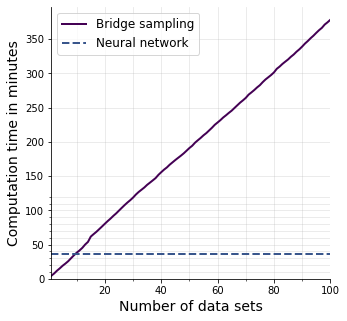

In [9]:
plot_computation_times(results_time_list, names=names, save=False)

In [10]:
# Get minimum number of datasets for which NNs are faster than bridge sampling

print(np.where(results_time_list[0] > results_time_list[1])[0][0]+1) # +1 as numpy uses 0-based indexing

10


# Put plots together for publication

In [16]:
# Prepare calibration plot

# Load network
summary_net = HierarchicalInvariantNetwork(summary_meta_validation)
probability_net = ModelProbabilityNetwork(probability_meta_validation)

amortizer = MultiModelAmortizer(probability_net, summary_net)

simulator = MainSimulator(HierarchicalSdtMptSimulator())

# Checkpoint path for loading pretrained network and saving the final network
checkpoint_path = "c:\\Users\\lasse\\documents\\hierarchical_model_comparison_project\\checkpoints\\02_bridge_sampling_comparison\\non_nested_models"

trainer = ModelComparisonTrainer(
    network=amortizer, 
    generative_model=simulator, 
    checkpoint_path=checkpoint_path,
    skip_checks=True
    )

# Sample size
n_clusters = 25
n_obs = 50

# Get repeated predictions for calibration curve with repetition uncertainty
n_repetitions = 25
n_data_sets = 5000

m_true_r, m_soft_r = get_repeated_predictions(probability_net, summary_net, 
                                              partial(simulator, batch_size=n_data_sets, n_obs=n_clust_obs_f_f(n_clusters, n_obs), n_vars=2), 
                                              n_models=2, n_repetitions=n_repetitions)

Networks loaded from c:\Users\lasse\documents\hierarchical_model_comparison_project\checkpoints\02_bridge_sampling_comparison\non_nested_models\ckpt-30


Median ECE = 0.0095148851028902
Median accuracy = 0.933


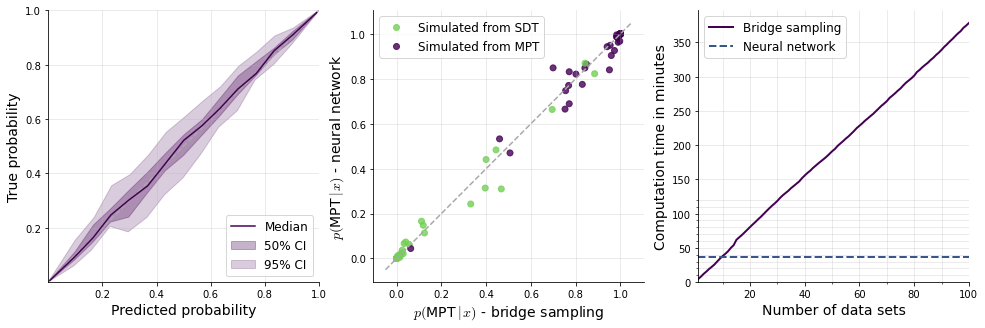

In [17]:
# Plot everything together
f, ax = plt.subplots(1, 3, figsize=(16.5,5))
plot_calibration_curve_repetition_uncertainty(m_true_r[:,:,1], m_soft_r[:,:,1], narrow_ci=[0.25, 0.75], wide_ci=[0.025, 0.975], n_bins=15, ax=ax[0], print_accuracy=True,
                                              xlabel=True, ylabel=True, title=None, show_ece=True, show_legend=True)
plot_approximations(bridge, NN_fixed, approximated_outcome='PMPs', 
                    NN_name='neural network', model_names=model_names, ax=ax[1])
plot_computation_times(results_time_list, names=names, ax=ax[2])

plt.savefig('BS_vs_NN_SDTMPT.pdf', dpi=300, bbox_inches='tight')